In [1]:
!apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
import os
os.environ["JAVA_HOME"]="/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java #setting the default JAVA version to JAVA 8
#Colab comes with JAVA11, and we are using Spark 3.x to use Pandas_UDF, where there is compatibility bug between the 3 interfaces. 
#Hence we specifically install JAVA-8

In [2]:
!java -version

openjdk version "1.8.0_292"
OpenJDK Runtime Environment (build 1.8.0_292-8u292-b10-0ubuntu1~18.04-b10)
OpenJDK 64-Bit Server VM (build 25.292-b10, mixed mode)


In [3]:
!pip install pyspark
#PySpark is Python binding for Spark. Spark being written in scala, we use PySpark to provide the necessary Python bindings.
#Underneath, the JAVA jar files uses the Py4j binding to connect to the scala version

In [4]:
!pip install pyarrow

In [5]:
!pip install fbprophet

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

from fbprophet import Prophet

mpl.rcParams['figure.figsize']=(10,8)
mpl.rcParams['axes.grid']=False

In [7]:
from pyspark.sql import SparkSession
import pyspark
spark = SparkSession.builder.master('local').getOrCreate()

In [8]:
df = pd.read_csv('https://raw.githubusercontent.com/srivatsan88/YouTubeLI/master/dataset/weekly_sales_data.csv')
df

,date,store_id,sales
0,1/6/2019,25,736657.2267
1,1/6/2019,26,233711.0000
2,1/6/2019,28,692156.3794
3,1/6/2019,29,213706.8000
4,1/6/2019,30,266455.0000
...,...,...,...
495,12/15/2019,31,401803.3590
496,12/15/2019,35,135799.1429
497,12/15/2019,38,115424.2250
498,12/15/2019,41,103375.0000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      500 non-null    object 
 1   store_id  500 non-null    int64  
 2   sales     500 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 11.8+ KB


In [10]:
df['date']=pd.to_datetime(df['date'],infer_datetime_format=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      500 non-null    datetime64[ns]
 1   store_id  500 non-null    int64         
 2   sales     500 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 11.8 KB


In [11]:
print("\nFeatures : \n", df.columns.tolist())
print("\nMissing Values : \n", df.isnull().any())
print("\nUnique Values : \n",df.nunique())


Features : 
 ['date', 'store_id', 'sales']

Missing Values : 
 date        False
store_id    False
sales       False
dtype: bool

Unique Values : 
 date         50
store_id     10
sales       500
dtype: int64


In [12]:
df

,date,store_id,sales
0,2019-01-06,25,736657.2267
1,2019-01-06,26,233711.0000
2,2019-01-06,28,692156.3794
3,2019-01-06,29,213706.8000
4,2019-01-06,30,266455.0000
...,...,...,...
495,2019-12-15,31,401803.3590
496,2019-12-15,35,135799.1429
497,2019-12-15,38,115424.2250
498,2019-12-15,41,103375.0000


In [13]:
df_base=df.copy()

In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
store_id,500.0,32.70000,6.171400,25.0,28.00000,30.50000,38.0000,44.000
sales,500.0,447080.02193,297065.969895,12788.0,252655.73375,315025.91375,684541.7596,1631584.985


In [15]:
df['store_id'].value_counts()

44    50
41    50
38    50
35    50
31    50
30    50
29    50
28    50
26    50
25    50
Name: store_id, dtype: int64

In [16]:
item_df=df.set_index('date')

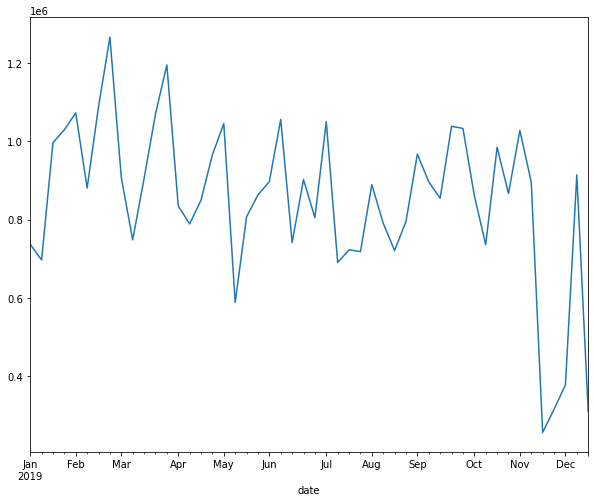

In [17]:
item_df.query("store_id==25")['sales'].plot()

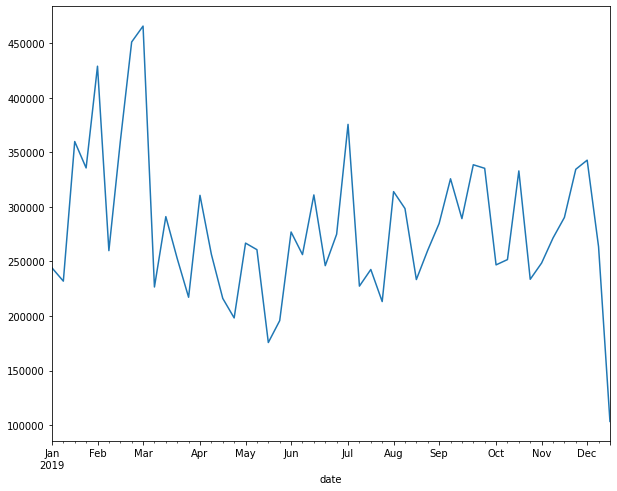

In [18]:
item_df.query("store_id==41")['sales'].plot()

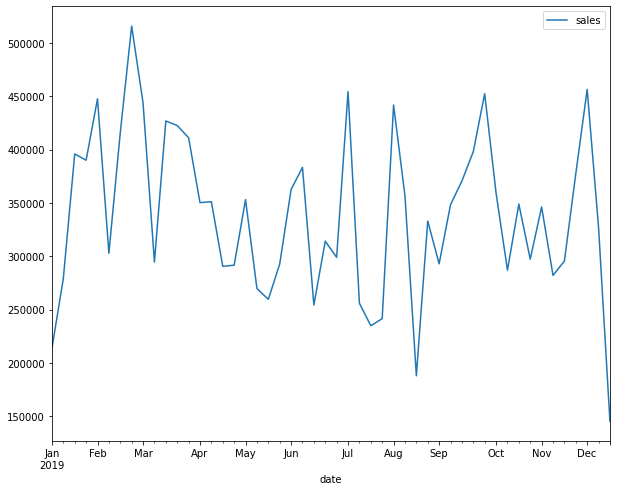

In [19]:
item_df.query("store_id==29")[['sales']].plot()

In [20]:
sdf = spark.createDataFrame(df) #creating a spark dataframe
sdf.show(5)

+-------------------+--------+-----------+
|               date|store_id|      sales|
+-------------------+--------+-----------+
|2019-01-06 00:00:00|      25|736657.2267|
|2019-01-06 00:00:00|      26|   233711.0|
|2019-01-06 00:00:00|      28|692156.3794|
|2019-01-06 00:00:00|      29|   213706.8|
|2019-01-06 00:00:00|      30|   266455.0|
+-------------------+--------+-----------+
only showing top 5 rows



In [21]:
sdf.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- store_id: long (nullable = true)
 |-- sales: double (nullable = true)



In [22]:
sdf.count()

500

In [23]:
sdf.select(['store_id']).groupBy('store_id').agg({'store_id':'count'}).show()

+--------+---------------+
|store_id|count(store_id)|
+--------+---------------+
|      26|             50|
|      29|             50|
|      31|             50|
|      25|             50|
|      41|             50|
|      28|             50|
|      44|             50|
|      35|             50|
|      38|             50|
|      30|             50|
+--------+---------------+



In [24]:
sdf.createOrReplaceTempView("sales")

In [25]:
spark.sql("select store_id, count(*) from sales group by store_id order by store_id").show()

+--------+--------+
|store_id|count(1)|
+--------+--------+
|      25|      50|
|      26|      50|
|      28|      50|
|      29|      50|
|      30|      50|
|      31|      50|
|      35|      50|
|      38|      50|
|      41|      50|
|      44|      50|
+--------+--------+



In [26]:
sql = 'SELECT store_id, date as ds, sum(sales) as y FROM sales GROUP BY store_id, ds ORDER BY store_id, ds'
#the dates are anyway on weekly basis, so grouping by store_id and date and then prforming a sum of sales is not very helpful. 
#store_id & date is a unique combination anyway.
#Prophet expects the date column to be named as ds and the target column to be named as y. Hence the above nomenclature

In [27]:
spark.sql(sql).show()

+--------+-------------------+------------------+
|store_id|                 ds|                 y|
+--------+-------------------+------------------+
|      25|2019-01-06 00:00:00|       736657.2267|
|      25|2019-01-13 00:00:00|       696457.1717|
|      25|2019-01-20 00:00:00|        996876.875|
|      25|2019-01-27 00:00:00|        1029737.05|
|      25|2019-02-03 00:00:00|       1072873.705|
|      25|2019-02-10 00:00:00|       880462.4681|
|      25|2019-02-17 00:00:00|        1088756.78|
|      25|2019-02-24 00:00:00|       1266928.313|
|      25|2019-03-03 00:00:00|       907510.1217|
|      25|2019-03-10 00:00:00|       747920.9824|
|      25|2019-03-17 00:00:00|       904750.3158|
|      25|2019-03-24 00:00:00|1069857.5890000002|
|      25|2019-03-31 00:00:00|       1195574.314|
|      25|2019-04-07 00:00:00|       834911.3333|
|      25|2019-04-14 00:00:00|       788777.4167|
|      25|2019-04-21 00:00:00|       849603.4333|
|      25|2019-04-28 00:00:00|        965521.165|


In [28]:
sdf.explain()

== Physical Plan ==
*(1) Scan ExistingRDD[date#0,store_id#1L,sales#2]




In [29]:
sdf.rdd.getNumPartitions() #all data in single partition

1

In [30]:
store_part=(spark.sql(sql).repartition(spark.sparkContext.defaultParallelism,['store_id'])).cache()
#repartitioning the data on the store_id column, and then caching it. The repartitioning leverages the sql statement we created at the top
#The different partitions are cached in memory so that iterative processes like ML, don't have to make repeated disk swipes, 
#but can directly leverage the data from memory

In [31]:
store_part

DataFrame[store_id: bigint, ds: timestamp, y: double]

In [32]:
store_part.explain()

== Physical Plan ==
InMemoryTableScan [store_id#1L, ds#83, y#84]
   +- InMemoryRelation [store_id#1L, ds#83, y#84], StorageLevel(disk, memory, deserialized, 1 replicas)
         +- Exchange hashpartitioning(store_id#1L, 1), REPARTITION_WITH_NUM, [id=#147]
            +- *(3) Sort [store_id#1L ASC NULLS FIRST, ds#83 ASC NULLS FIRST], true, 0
               +- Exchange rangepartitioning(store_id#1L ASC NULLS FIRST, ds#83 ASC NULLS FIRST, 200), ENSURE_REQUIREMENTS, [id=#143]
                  +- *(2) HashAggregate(keys=[store_id#1L, date#0], functions=[sum(sales#2)])
                     +- Exchange hashpartitioning(store_id#1L, date#0, 200), ENSURE_REQUIREMENTS, [id=#139]
                        +- *(1) HashAggregate(keys=[store_id#1L, date#0], functions=[partial_sum(sales#2)])
                           +- *(1) Scan ExistingRDD[date#0,store_id#1L,sales#2]




In [37]:
from pyspark.sql.types import *

result_schema =StructType([
  StructField('ds',TimestampType()),
  StructField('store_id',IntegerType()),
  StructField('y',DoubleType()),
  StructField('yhat',DoubleType()), #Prophet predicted values
  StructField('yhat_upper',DoubleType()), #Confidence upper threshold
  StructField('yhat_lower',DoubleType())  #Confidence lower threshold
  ])
#creating a result_schema for return object from UDF object
#when Prophet predicts an outcome, we can mention the confidence interval of the values

In [38]:
from pyspark.sql.functions import pandas_udf, PandasUDFType
#pandas_udf is very useful for vectorised user-defined functions

@pandas_udf( result_schema, PandasUDFType.GROUPED_MAP )
def forecast_sales( store_pd ):
  #defining the function to be a pandas udf function, providing as output the above defined result_schema & PandasUDFType GROPUED_MAP
  #usually spark UDFs execute row-by-row, so for each row that spark reads, it will execute the same.
  #GROPUED_MAP allows us to vectorize a particular set of rows, here our chunk of data partitioned by store_id, and execute on similar lines
  #as spark UDFs. So our chunk of data partitioned by store_id is vectorized for processing by Prophet leveraging spark UDF.  
  #The function forecast_sales takes as input a spark df but once inside, it's converted to a pandas dataframe, using pyarrow.

  model = Prophet(interval_width=0.95,seasonality_mode = 'multiplicative', weekly_seasonality=True, yearly_seasonality=True)
  #confidence interval is 95%. seasonality_mode = 'multiplicative' due to the ups-and-downs, which execute without any fixed trend.
  #As we have ony one year of data over here, we are assuming that the product sales follow the same pattern over the years. 
  #However in cases where it is observed to be not true, we can create multiple pandas udfs, 
  #seperate for these stores and execute seperate models for those stores.

  model.fit( store_pd )

  future_pd = model.make_future_dataframe(
    periods=5, 
    freq='w'
    )
  #telling to predict for next 5 weeks as the i/p data is weekly
  
  forecast_pd = model.predict( future_pd )  
  
  f_pd = forecast_pd[ ['ds','yhat', 'yhat_upper', 'yhat_lower'] ].set_index('ds')
  
  st_pd = store_pd[['ds','store_id','y']].set_index('ds')
  
  results_pd = f_pd.join( st_pd, how='left' )
  results_pd.reset_index(level=0, inplace=True)#joining the predicted dataframe and actual dataframe
  
  results_pd['store_id'] = store_pd['store_id'].iloc[0]

  return results_pd[ ['ds', 'store_id','y', 'yhat', 'yhat_upper', 'yhat_lower'] ] #returning the joined predicted & actual dataframes.
  #This is in the same format as the result_schema defined on top

In [39]:
from pyspark.sql.functions import current_date

results = (
  store_part
    .groupBy('store_id')
    .apply(forecast_sales)
    .withColumn('training_date', current_date() )
    )
#creating a new dataframe which is created after executing 'forecast_sales' on top of 'store_part', grouped by 'store_id' and having a new
#column called 'training_date' which stores the current execution date
#the groupBy('store_id') vectorizes the column as we have created a pandas_udf grouped_map. Thus we will have each store_id being vectorized
#and being passed as our top UDF.

/usr/local/lib/python3.7/dist-packages/pyspark/sql/pandas/group_ops.py:84: UserWarning:

It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.



In [40]:
results.cache()

DataFrame[ds: timestamp, store_id: int, y: double, yhat: double, yhat_upper: double, yhat_lower: double, training_date: date]

In [41]:
results.show()

+-------------------+--------+------------------+------------------+------------------+------------------+-------------+
|                 ds|store_id|                 y|              yhat|        yhat_upper|        yhat_lower|training_date|
+-------------------+--------+------------------+------------------+------------------+------------------+-------------+
|2019-01-06 00:00:00|      25|       736657.2267| 712575.0694095818|  957293.821178207|469778.99251664866|   2021-08-05|
|2019-01-13 00:00:00|      25|       696457.1717| 743751.7568979745| 981624.5758589035| 516482.7028168082|   2021-08-05|
|2019-01-20 00:00:00|      25|        996876.875| 972909.8778074606|1216081.7899964782| 738035.3445249255|   2021-08-05|
|2019-01-27 00:00:00|      25|        1029737.05|1034447.5557655566| 1286643.895628955| 825902.8521564458|   2021-08-05|
|2019-02-03 00:00:00|      25|       1072873.705| 986365.7266813249|1213388.2814925665| 728874.3869406501|   2021-08-05|
|2019-02-10 00:00:00|      25|  

In [42]:
results.explain()

== Physical Plan ==
InMemoryTableScan [ds#213, store_id#214, y#215, yhat#216, yhat_upper#217, yhat_lower#218, training_date#225]
   +- InMemoryRelation [ds#213, store_id#214, y#215, yhat#216, yhat_upper#217, yhat_lower#218, training_date#225], StorageLevel(disk, memory, deserialized, 1 replicas)
         +- *(2) Project [ds#213, store_id#214, y#215, yhat#216, yhat_upper#217, yhat_lower#218, 18844 AS training_date#225]
            +- FlatMapGroupsInPandas [store_id#1L], forecast_sales(store_id#1L, ds#156, y#157), [ds#213, store_id#214, y#215, yhat#216, yhat_upper#217, yhat_lower#218]
               +- *(1) Sort [store_id#1L ASC NULLS FIRST], false, 0
                  +- InMemoryTableScan [store_id#1L, store_id#1L, ds#156, y#157]
                        +- InMemoryRelation [store_id#1L, ds#156, y#157], StorageLevel(disk, memory, deserialized, 1 replicas)
                              +- Exchange hashpartitioning(store_id#1L, 1), REPARTITION_WITH_NUM, [id=#147]
                          

In [43]:
results.coalesce(1)
#opposite of repartitng we are creating a huge file so that we can easily query it. this prevents flow of data from multiple partitions
#when we want to analyse the data

DataFrame[ds: timestamp, store_id: int, y: double, yhat: double, yhat_upper: double, yhat_lower: double, training_date: date]

In [44]:
results.count()
#initially we had 500 rows of data. Now that we have predicted next 5 weeks of sales for 10 stores, we have 550 rows of data

550

In [45]:
results.createOrReplaceTempView('forecasted')

In [46]:
spark.sql("select store_id, count(*) from forecasted group by store_id").show()
#each store is now having 55 values, as against the initial 50 values

+--------+--------+
|store_id|count(1)|
+--------+--------+
|      31|      55|
|      28|      55|
|      26|      55|
|      44|      55|
|      41|      55|
|      35|      55|
|      38|      55|
|      25|      55|
|      29|      55|
|      30|      55|
+--------+--------+



In [47]:
final_df = results.toPandas()
final_df

,ds,store_id,y,yhat,yhat_upper,yhat_lower,training_date
0,2019-01-06,25,7.366572e+05,7.125751e+05,9.572938e+05,469778.992517,2021-08-05
1,2019-01-13,25,6.964572e+05,7.437518e+05,9.816246e+05,516482.702817,2021-08-05
2,2019-01-20,25,9.968769e+05,9.729099e+05,1.216082e+06,738035.344525,2021-08-05
3,2019-01-27,25,1.029737e+06,1.034448e+06,1.286644e+06,825902.852156,2021-08-05
4,2019-02-03,25,1.072874e+06,9.863657e+05,1.213388e+06,728874.386941,2021-08-05
...,...,...,...,...,...,...,...
545,2019-12-22,44,NaN,6.265474e+04,1.286395e+05,1694.676273,2021-08-05
546,2019-12-29,44,NaN,2.657442e+04,9.158029e+04,-38981.046269,2021-08-05
547,2020-01-05,44,NaN,8.801264e+03,7.469218e+04,-52808.297346,2021-08-05
548,2020-01-12,44,NaN,4.665900e+03,6.986122e+04,-59845.018104,2021-08-05


In [48]:
final_df=final_df.set_index('ds')

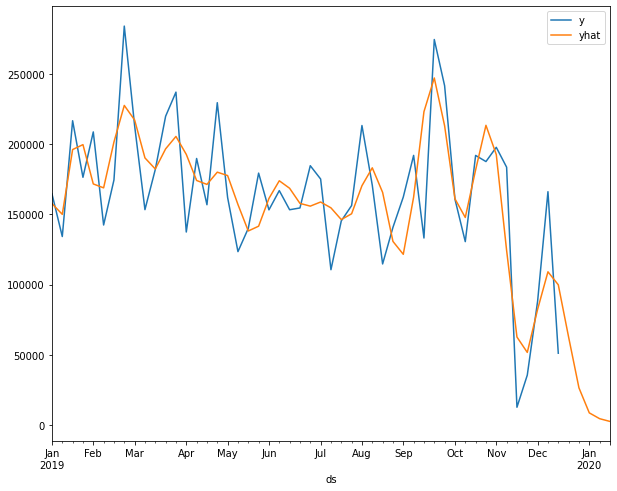

In [49]:
final_df.query('store_id==44')[['y','yhat']].plot()

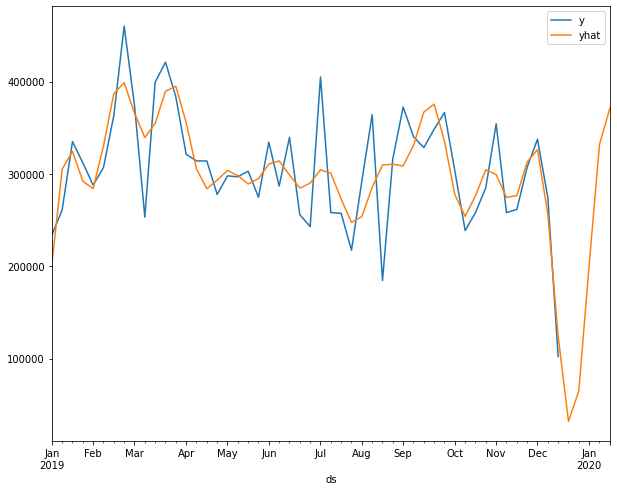

In [50]:
final_df.query('store_id==26')[['y','yhat']].plot()

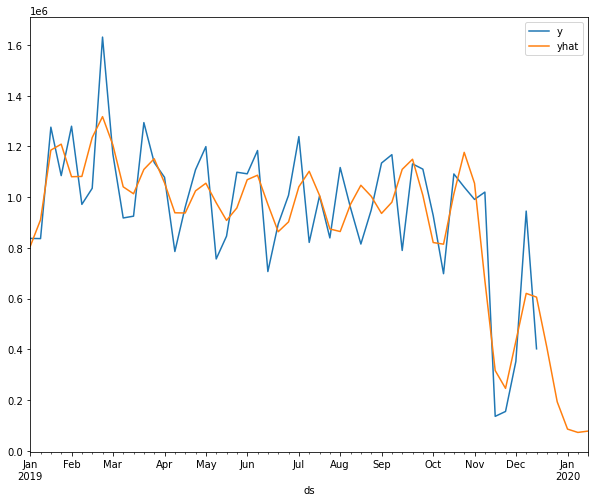

In [51]:
final_df.query('store_id==31')[['y','yhat']].plot()